# 2020 Presidential Election Time Series
## Project Setup

In [1]:
%run get_data.py

Repo: 'origin': https://github.com/ElectProject/Early-Vote-2020G.git
Total commits: 1317
docs/index.html commits: 588


,commit,datetime,vote_id,vote_total,request_id,request_total
1,3e5737d576a0c55d97d45b31624d20a82eaf781d,2020-10-31 15:56:00-04:00,total-voted,90488149,mail-ballots-requested,91033492
2,d82a0f7d51525fbbd2ada6b1559e596132ec9876,2020-10-31 15:40:00-04:00,total-voted,90343882,mail-ballots-requested,91032140
3,b13800a1cba0434bb59827c94fe8314456392af5,2020-10-31 12:21:00-04:00,total-voted,90285812,mail-ballots-requested,91032140
4,b5d47e63d687321d17063aaaf5f853aedf79a7ee,2020-10-31 11:27:00-04:00,total-voted,90055033,mail-ballots-requested,91030652
5,40ae74eb015ed80d2746edb7de70b8d19aac07f2,2020-10-31 11:17:00-04:00,total-voted,90012433,mail-ballots-requested,91029849
...,...,...,...,...,...,...
583,55ef4d8da4c860460a99cff8d2e7dac0605a857d,2020-09-01 22:55:00-04:00,NaN,NaN,NaN,12743272
584,ff3f92d8e11b8a23335cddf64e5799c74912ec52,2020-09-01 22:08:00-04:00,NaN,NaN,NaN,12623324
585,52ba37e4bd3605ab83b71358536ddf26d54b395d,2020-09-01 20:43:00-04:00,NaN,NaN,national-statistics,12623324
586,d34181643d565305eff7486090acbe9329c48d31,2020-09-01 15:48:00-04:00,NaN,NaN,national-statistics,12623324


,datetime,vote_total_2016
0,2020-09-25 22:59:00-04:00,9525
1,2020-10-02 22:59:00-04:00,74836
2,2020-10-09 22:59:00-04:00,429337
3,2020-10-16 22:59:00-04:00,1400000
4,2020-10-23 22:59:00-04:00,5900000
5,2020-10-30 22:59:00-04:00,21000000
6,2020-11-02 22:59:00-05:00,46220922
7,2020-11-03 22:59:00-05:00,136452150


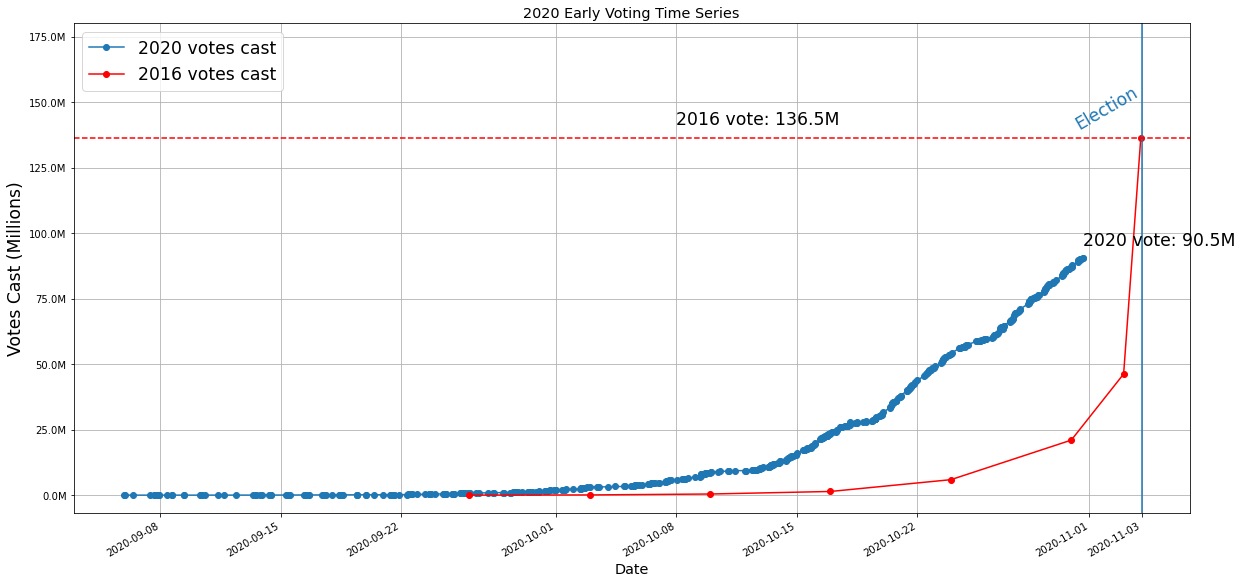

Loading BokehJS ...

In [2]:
update_notebook()